<a href="https://colab.research.google.com/github/ShFANI/ShFANI.github.io/blob/main/Breast_cancer_decision_tree_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast Cancer Diagnosis Using Decision Trees

This notebook walks through a practical comparison:

1. **Decision Tree (no feature selection)**  
2. **Decision Tree + Feature Selection** (done *properly* inside cross‑validation to avoid leakage)

We’ll evaluate both on a held‑out test set and visualize the results (confusion matrix + ROC curve), then summarize what we learned.

> **Dataset**: Wisconsin Breast Cancer (diagnosis = *Benign* vs *Malignant*).  



# Step 1: Import Libraries

In [ ]:
# --- Setup: imports ---
import os
import numpy as np
import pandas as pd
import seaborn as sns
import itertools
import graphviz
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, ConfusionMatrixDisplay, RocCurveDisplay)
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn import tree
%matplotlib inline


# Step 2: Load the data



In [ ]:
from google.colab import files
data = files.upload()   # choose Data.csv from your computer


Saving data.csv to data.csv


In [ ]:
df = pd.read_csv("data.csv")
df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,NaN
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,NaN
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,NaN
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,NaN
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,NaN


#Step 3: Describe Data

In [ ]:
#  Build a "target" column (1=malignant, 0=benign)
df["target"] = df["diagnosis"].map({"M": 1, "B": 0})

# Create sizeMeasurements = [features + target]
#    Remove non-feature columns if present
drop_cols = [c for c in ["id", "Unnamed: 32", "diagnosis"] if c in df.columns]

feature_df = df.drop(columns=drop_cols + ["target"], errors="ignore")
feature_df = feature_df.select_dtypes(include=[np.number])  # ensure numeric

sizeMeasurements = pd.concat([feature_df, df["target"]], axis=1)

#
X = sizeMeasurements[sizeMeasurements.columns[:-1]]
y = sizeMeasurements["target"]

X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\n Feature Names:\n\n", X.columns.values, "\n")
print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Target counts:\n", y.value_counts())


 Feature Names:

 ['radius_mean' 'texture_mean' 'perimeter_mean' 'area_mean'
 'smoothness_mean' 'compactness_mean' 'concavity_mean'
 'concave points_mean' 'symmetry_mean' 'fractal_dimension_mean'
 'radius_se' 'texture_se' 'perimeter_se' 'area_se' 'smoothness_se'
 'compactness_se' 'concavity_se' 'concave points_se' 'symmetry_se'
 'fractal_dimension_se' 'radius_worst' 'texture_worst' 'perimeter_worst'
 'area_worst' 'smoothness_worst' 'compactness_worst' 'concavity_worst'
 'concave points_worst' 'symmetry_worst' 'fractal_dimension_worst'] 

Train shape: (455, 30) Test shape: (114, 30)
Target counts:
 target
0    357
1    212
Name: count, dtype: int64


# Step 4: Plot Data

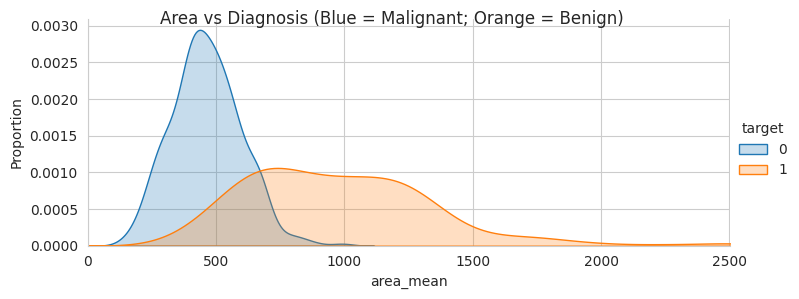

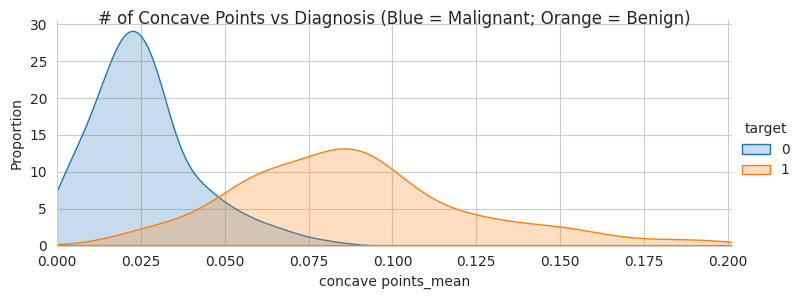

In [ ]:
sns.set_style("whitegrid")

# Plot 1: area_mean (the average area (size) of the cell nuclei in the sample)
plotOne = sns.FacetGrid(sizeMeasurements, hue="target", aspect=2.5)
plotOne.map(sns.kdeplot, "area_mean", fill=True)   # <-- changed
plotOne.set(xlim=(0, sizeMeasurements["area_mean"].max()))
plotOne.add_legend()
plotOne.set_axis_labels("area_mean", "Proportion")
plotOne.fig.suptitle("Area vs Diagnosis (Blue = Malignant; Orange = Benign)")
plt.show()

# Plot 2: concave points_mean (the average number/proportion of concave points on the boundary of the nuclei)
sns.set_style("whitegrid")
plotTwo = sns.FacetGrid(sizeMeasurements, hue="target", aspect=2.5)
plotTwo.map(sns.kdeplot, "concave points_mean", fill=True)  # <-- changed
plotTwo.set(xlim=(0, sizeMeasurements["concave points_mean"].max()))
plotTwo.add_legend()
plotTwo.set_axis_labels("concave points_mean", "Proportion")
plotTwo.fig.suptitle("# of Concave Points vs Diagnosis (Blue = Malignant; Orange = Benign)")
plt.show()





Both plots show that area_mean and concave_points_mean separate the classes very well, because the distributions are clearly shifted with limited overlap. In other words, a classifier (like a decision tree) can use these features to split malignant vs benign effectively.

#Step 4: Feature Selection

Here I will compare three methods for feature selection: (1) No feature selection; (2) retain only features that are not correlated; (3) use PCA transformation to select features and reduce feature correlation.

(1) No feature selection


Feature Correlation:



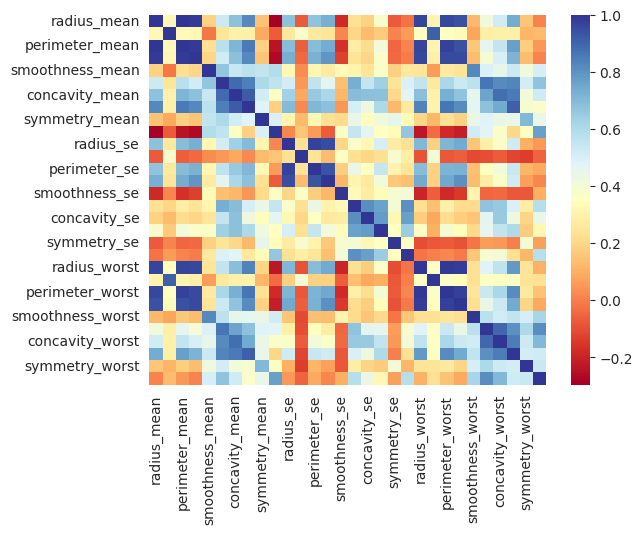

In [ ]:
print("\nFeature Correlation:\n")
g = sns.heatmap(X_train.corr(),cmap='RdYlBu',annot=False)

(2) retain only features that are not correlated

In [ ]:
sizeMeasurements2 = sizeMeasurements.drop(['radius_mean','perimeter_mean','smoothness_mean','compactness_mean',
 'concavity_mean','concave points_mean', 'fractal_dimension_mean','radius_se','texture_se','perimeter_se',
 'area_se','smoothness_se', 'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se', 'fractal_dimension_se', 'radius_worst',
 'texture_worst', 'perimeter_worst', 'area_worst', 'smoothness_worst', 'compactness_worst', 'concavity_worst', 'concave points_worst', 'symmetry_worst',
 'fractal_dimension_worst'], axis=1)



 Feature Names: 

 ['texture_mean' 'area_mean' 'symmetry_mean'] 


Feature Correlation:



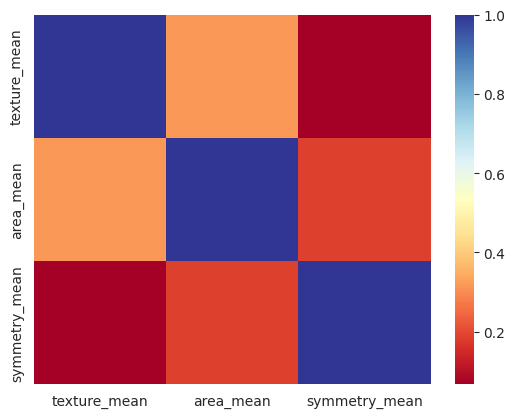

In [ ]:
X2 = sizeMeasurements2[sizeMeasurements2.columns[:-1]]
y2 = sizeMeasurements2.target
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, y2, test_size=0.2)
print('\n Feature Names: \n\n', X2.columns.values, "\n")
print("\nFeature Correlation:\n")
g = sns.heatmap(X_train2.corr(),cmap='RdYlBu',annot=False)

(3) use PCA transformation to select features and reduce feature correlation.


 Feature Names: 

 [0 1 2 3 4] 


Feature Correlation:



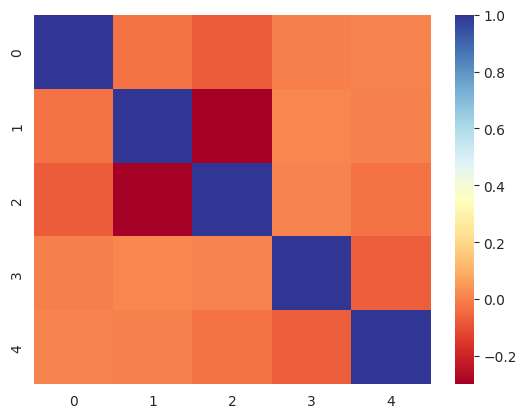

In [ ]:
from sklearn.decomposition import PCA
X3=X
y3=y
variance_pct = 5 # Minimum percentage of variance we want to be described by the resulting transformed components
pca = PCA(n_components=variance_pct) # Create PCA object
X_transformed = pca.fit_transform(X3,y3) # Transform the initial features
X3pca = pd.DataFrame(X_transformed) # Create a data frame from the PCA'd data
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3pca, y3, test_size=0.2)
print('\n Feature Names: \n\n', X3pca.columns.values, "\n")
#print('First Few Values, After PCA: \n\n,',X3pca.head(),'\n\n')
print("\nFeature Correlation:\n")
g = sns.heatmap(X_train3.corr(),cmap='RdYlBu',annot=False)

## Step 5: Evaluate Model Performance

We tune a few key hyperparameters:
- `max_depth` controls model complexity (too deep → overfit)
- `min_samples_leaf` stabilizes splits (bigger → smoother)
- `class_weight="balanced"` helps if classes aren’t perfectly balanced

We optimize using **ROC-AUC** because it uses predicted probabilities and is threshold-free.


In [ ]:
from sklearn import tree

clf1 = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=12, class_weight="balanced", random_state=42)
clf1.fit(X_train, Y_train)

clf2 = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=12, class_weight="balanced", random_state=42)
clf2.fit(X_train2, Y_train2)

clf3 = tree.DecisionTreeClassifier(max_depth=3, min_samples_leaf=12, class_weight="balanced", random_state=42)
clf3.fit(X_train3, Y_train3)

print('Accuracy of Decision Tree classifier on original training set: {:.2f}'.format(clf1.score(X_train, Y_train)))
print('Accuracy of Decision Tree classifier on original test set: {:.2f}'.format(clf1.score(X_test, Y_test)))

print('Accuracy of Decision Tree classifier on reduced training set: {:.2f}'.format(clf2.score(X_train2, Y_train2)))
print('Accuracy of Decision Tree classifier on reduced test set: {:.2f}'.format(clf2.score(X_test2, Y_test2)))

print('Accuracy of Decision Tree classifier on PCA-transformed training set: {:.2f}'.format(clf3.score(X_train3, Y_train3)))
print('Accuracy of Decision Tree classifier on PCA-transformed test set: {:.2f}'.format(clf3.score(X_test3, Y_test3)))


Accuracy of Decision Tree classifier on original training set: 0.96
Accuracy of Decision Tree classifier on original test set: 0.93
Accuracy of Decision Tree classifier on reduced training set: 0.93
Accuracy of Decision Tree classifier on reduced test set: 0.85
Accuracy of Decision Tree classifier on PCA-transformed training set: 0.95
Accuracy of Decision Tree classifier on PCA-transformed test set: 0.96


# With GridSearchCV

In [ ]:
import numpy as np
import pandas as pd

from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix

# -----------------------------
# 1) CV + parameter grid
# -----------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_grid = {
    "max_depth": [2, 3, 4, 5, 6, 8, 10, None],
    "min_samples_leaf": [1, 2, 5, 10, 12, 15, 20],
    "class_weight": [None, "balanced"]
}

def gridsearch_tree(Xtr, ytr, Xte, yte, name):
    base = DecisionTreeClassifier(random_state=42)

    gs = GridSearchCV(
        estimator=base,
        param_grid=param_grid,
        scoring="roc_auc",     # better than accuracy for imbalanced / medical
        cv=cv,
        n_jobs=-1,
        refit=True
    )

    gs.fit(Xtr, ytr)
    best_model = gs.best_estimator_

    # Test metrics
    proba = best_model.predict_proba(Xte)[:, 1]
    pred = best_model.predict(Xte)

    test_acc = accuracy_score(yte, pred)
    test_auc = roc_auc_score(yte, proba)

    return {
        "name": name,
        "best_model": best_model,
        "best_params": gs.best_params_,
        "cv_best_auc": gs.best_score_,
        "test_acc": test_acc,
        "test_auc": test_auc
    }

# -----------------------------
# 2) Run GridSearch on each dataset
# -----------------------------
res1 = gridsearch_tree(X_train,  Y_train,  X_test,  Y_test,  "Original features")
res2 = gridsearch_tree(X_train2, Y_train2, X_test2, Y_test2, "Reduced (correlation filtered) features")
res3 = gridsearch_tree(X_train3, Y_train3, X_test3, Y_test3, "PCA-transformed features")

results = [res1, res2, res3]

# -----------------------------
# 3) Print results for each
# -----------------------------
for r in results:
    print("="*60)
    print(r["name"])
    print("Best params:", r["best_params"])
    print(f"Best CV ROC-AUC: {r['cv_best_auc']:.4f}")
    print(f"Test ROC-AUC:    {r['test_auc']:.4f}")
    print(f"Test Accuracy:   {r['test_acc']:.4f}")

# -----------------------------
# 4) Choose the best model (by CV ROC-AUC)
# -----------------------------
best = max(results, key=lambda d: d["cv_best_auc"])

print("\n" + "#"*60)
print("🏆 BEST MODEL (by CV ROC-AUC)")
print("Dataset:", best["name"])
print("Best params:", best["best_params"])
print(f"Best CV ROC-AUC: {best['cv_best_auc']:.4f}")
print(f"Test ROC-AUC:    {best['test_auc']:.4f}")
print(f"Test Accuracy:   {best['test_acc']:.4f}")
print("#"*60)

best_model = best["best_model"]  # <-- this is your final best decision tree


Original features
Best params: {'class_weight': 'balanced', 'max_depth': 4, 'min_samples_leaf': 10}
Best CV ROC-AUC: 0.9754
Test ROC-AUC:    0.9876
Test Accuracy:   0.9298
Reduced (correlation filtered) features
Best params: {'class_weight': 'balanced', 'max_depth': 5, 'min_samples_leaf': 20}
Best CV ROC-AUC: 0.9570
Test ROC-AUC:    0.9198
Test Accuracy:   0.8509
PCA-transformed features
Best params: {'class_weight': None, 'max_depth': 4, 'min_samples_leaf': 10}
Best CV ROC-AUC: 0.9798
Test ROC-AUC:    0.9767
Test Accuracy:   0.9561

############################################################
🏆 BEST MODEL (by CV ROC-AUC)
Dataset: PCA-transformed features
Best params: {'class_weight': None, 'max_depth': 4, 'min_samples_leaf': 10}
Best CV ROC-AUC: 0.9798
Test ROC-AUC:    0.9767
Test Accuracy:   0.9561
############################################################


Among your three feature versions:

the PCA version produced the highest average CV ROC-AUC, so it generalized best during cross-validation.

CV ROC-AUC vs Test ROC-AUC:

Best CV ROC-AUC = 0.9798, Test ROC-AUC = 0.9767

These are very close, which is a good sign:



*   It means the model selection wasn’t just overfitting to CV folds.
*   The model generalizes well to unseen test data.




## Step 6: Plots — Confusion Matrix + ROC curves

- **Confusion Matrix** shows the types of errors (especially false negatives).
- **ROC curve** shows performance across all thresholds (not just 0.5).


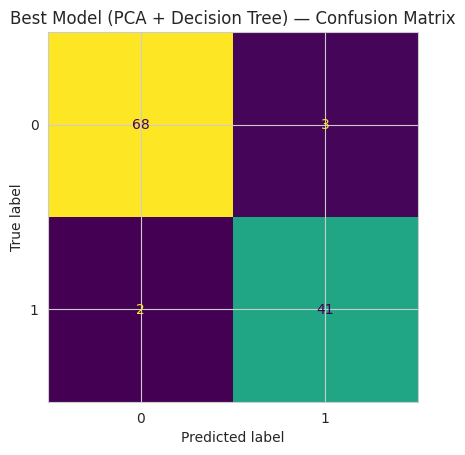

<Figure size 600x500 with 0 Axes>

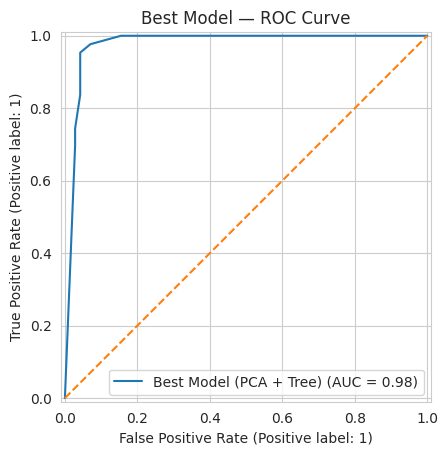

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

# If your best model is the PCA pipeline:
# best_model = best3   # example name
pred_best  = best_model.predict(X_test3)
proba_best = best_model.predict_proba(X_test3)[:, 1]

# Confusion matrix
ConfusionMatrixDisplay.from_predictions(
    Y_test3, pred_best, colorbar=False, values_format="d"
)
plt.title("Best Model (PCA + Decision Tree) — Confusion Matrix")
plt.show()

# ROC curve
plt.figure(figsize=(6, 5))
RocCurveDisplay.from_predictions(Y_test3, proba_best, name="Best Model (PCA + Tree)")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.title("Best Model — ROC Curve")
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

def plot_tree_and_decision_boundary(
    best_model,
    X_train, y_train,
    class_names=("Benign (0)", "Malignant (1)"),
    boundary_resolution=400,
    max_depth_tree_plot=4
):
    """
    1) Plots the decision tree from best_model
    2) Plots decision boundary in 2D PCA space (PC1, PC2) using the same tree hyperparameters

    best_model: fitted sklearn Pipeline (ideally scaler -> pca -> model) OR fitted DecisionTreeClassifier.
    X_train: pandas DataFrame of original features
    y_train: array-like labels (0/1)
    """

    # -------------------------
    # Part A: Plot the TREE
    # -------------------------
    # Extract the decision tree classifier
    clf = None
    if isinstance(best_model, Pipeline):
        clf = best_model.named_steps["model"] if "model" in best_model.named_steps else best_model.named_steps["classifier"]
    elif isinstance(best_model, DecisionTreeClassifier):
        clf = best_model
    else:
        raise ValueError("best_model must be a Pipeline with a 'model' step (DecisionTreeClassifier) or a DecisionTreeClassifier directly.")

    # Determine feature names for the tree plot
    feature_names_for_tree = []
    if isinstance(best_model, Pipeline) and "pca" in best_model.named_steps:
        n_comp = best_model.named_steps["pca"].n_components_
        feature_names_for_tree = [f"PC{i+1}" for i in range(n_comp)]
    elif best["name"] == "PCA-transformed features": # Use the 'best' dict from global scope
        feature_names_for_tree = X3pca.columns.astype(str).tolist()
    elif best["name"] == "Reduced (correlation filtered) features":
        feature_names_for_tree = X2.columns.tolist()
    elif best["name"] == "Original features":
        feature_names_for_tree = X.columns.tolist()
    else:
        # Fallback if no specific feature names can be determined
        n_feat = clf.n_features_in_
        feature_names_for_tree = [f"x{i+1}" for i in range(n_feat)]

    plt.figure(figsize=(20, 8))
    plot_tree(
        clf,
        feature_names=feature_names_for_tree,
        class_names=list(class_names),
        filled=True,
        rounded=True,
        impurity=False,
        proportion=True,
        max_depth=max_depth_tree_plot
    )
    plt.title("Best Model — Decision Tree (top levels shown)")
    plt.show()

    # ---------------------------------------------------------
    # Part B: Plot DECISION BOUNDARY (needs 2D)
    # We'll create a 2D PCA version with SAME tree hyperparams.
    # ---------------------------------------------------------
    tree_params = clf.get_params()

    boundary_pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
        ("model", DecisionTreeClassifier(
            random_state=tree_params.get("random_state", 42),
            max_depth=tree_params.get("max_depth", None),
            min_samples_leaf=tree_params.get("min_samples_leaf", 1),
            class_weight=tree_params.get("class_weight", None)
        ))
    ])

    boundary_pipe.fit(X_train, y_train)

    # Transform train points to 2D PCA for plotting
    X_train_2d = boundary_pipe.named_steps["pca"].transform(
        boundary_pipe.named_steps["scaler"].transform(X_train)
    )

    # Create mesh grid in PC space
    x_min, x_max = X_train_2d[:, 0].min() - 1, X_train_2d[:, 0].max() + 1
    y_min, y_max = X_train_2d[:, 1].min() - 1, X_train_2d[:, 1].max() + 1

    xx, yy = np.meshgrid(
        np.linspace(x_min, x_max, boundary_resolution),
        np.linspace(y_min, y_max, boundary_resolution)
    )

    grid = np.c_[xx.ravel(), yy.ravel()]

    # Predict on grid using the tree trained on PC1/PC2
    tree_2d = boundary_pipe.named_steps["model"]
    proba = tree_2d.predict_proba(grid)[:, 1].reshape(xx.shape)

    # Plot probability surface + boundary + points
    plt.figure(figsize=(9, 7))
    plt.contourf(xx, yy, proba, alpha=0.35, levels=20)
    plt.contour(xx, yy, proba, levels=[0.5], linewidths=2)  # decision boundary at 0.5

    plt.scatter(
        X_train_2d[:, 0], X_train_2d[:, 1],
        c=y_train, s=20, edgecolor="k", alpha=0.85
    )

    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.title("Decision Boundary of Best Tree (visualized in PCA 2D space)")
    plt.show()

    return boundary_pipe  # returns the 2D visualization model (optional)


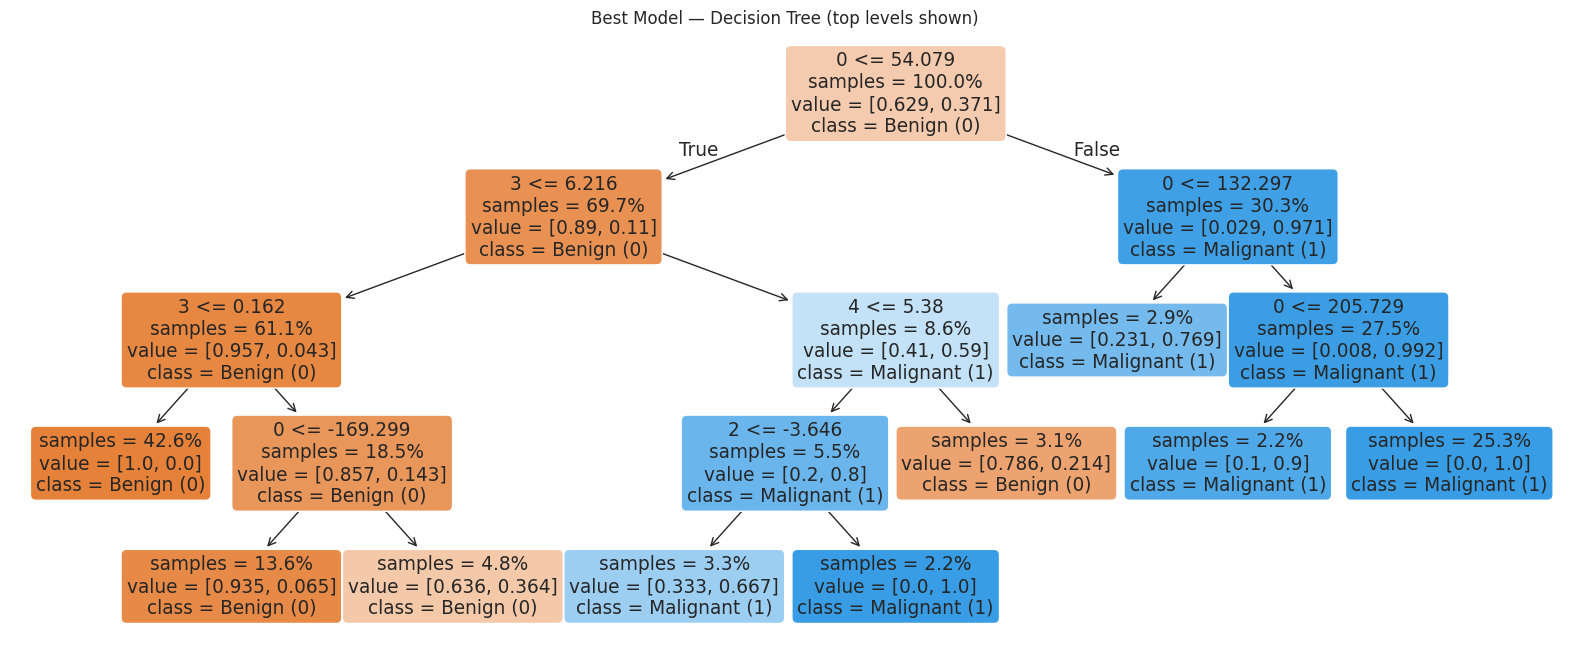

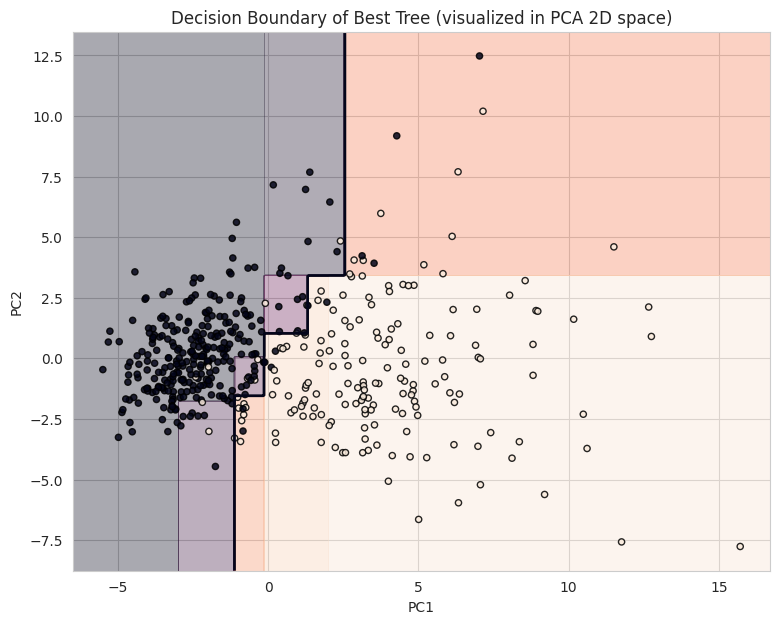

Pipeline(steps=[('scaler', StandardScaler()),
                ('pca', PCA(n_components=2, random_state=42)),
                ('model',
                 DecisionTreeClassifier(max_depth=4, min_samples_leaf=10,
                                        random_state=42))])

In [ ]:
# Example: best_model = best3  OR gs3.best_estimator_
plot_tree_and_decision_boundary(best_model, X_train, Y_train)
